In [ ]:
!mkdir ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d emmarex/plantdisease -p /content --unzip

 99% 652M/658M [00:07<00:00, 121MB/s] 
100% 658M/658M [00:07<00:00, 91.7MB/s]


In [ ]:
import numpy as np 
import pickle
import cv2
import matplotlib.pyplot as plt

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

#Keras for the model 
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
def convert_image_to_array(image_dir):
    try:
        img = cv2.imread(image_dir)
        if img is not None :
            img = cv2.resize(img, default_image_size)   
            return img_to_array(img)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image, 0)
    plt.imshow(plt.imread(image_path))
    predictions = model.predict(np_image)
    predicted_class_index = np.argmax(predictions)
    predicted_class = image_labels.classes_[predicted_class_index]
    print(predicted_class)

In [ ]:
#Directory where the data is stored
directory_root = '/content/plantvillage'

#Image specs
image_size = 0
width=256
height=256
depth=3

default_image_size = tuple((256, 256))

In [ ]:
#Here we obtain the images from the different labelled folder.
image_list, label_list = [], []


try:
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"Folder {plant_disease_folder} processing done...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

Folder Tomato__Tomato_mosaic_virus processing done...
Folder Pepper__bell___Bacterial_spot processing done...
Folder Tomato_Late_blight processing done...
Folder Tomato_healthy processing done...
Folder Pepper__bell___healthy processing done...
Folder Potato___Late_blight processing done...
Folder Tomato_Septoria_leaf_spot processing done...
Folder Tomato_Early_blight processing done...
Folder Tomato__Tomato_YellowLeaf__Curl_Virus processing done...
Folder Tomato_Bacterial_spot processing done...
Folder Tomato_Spider_mites_Two_spotted_spider_mite processing done...
Folder Potato___healthy processing done...
Folder Potato___Early_blight processing done...
Folder Tomato__Target_Spot processing done...
Folder Tomato_Leaf_Mold processing done...
Image loading completed


In [ ]:
image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
#Now we split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
#Training specs
EPOCHS = 1
INIT_LR = 1e-3
BS = 32

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [ ]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [ ]:
#Train the model
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

73/73 [==============================] - 675s 9s/step - loss: 0.5518 - accuracy: 0.2499 - val_loss: 0.8444 - val_accuracy: 0.0508


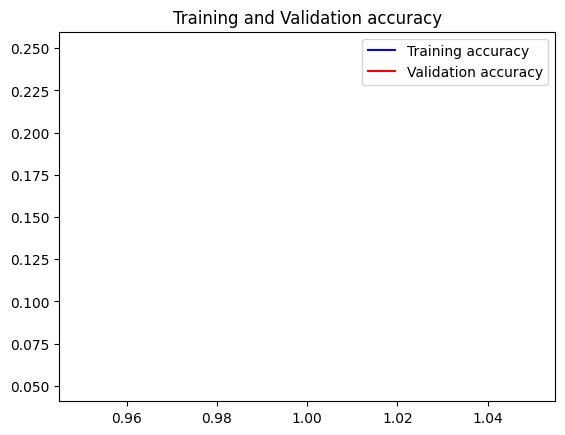

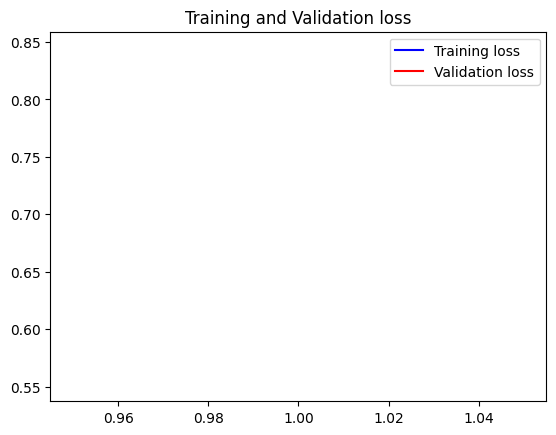

In [ ]:
if 'accuracy' in history.history:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
elif 'acc' in history.history:
    acc = history.history['acc']
    val_acc = history.history['val_acc']
else:
    raise KeyError("Could not find accuracy or acc in history object.")

if 'loss' in history.history:
    loss = history.history['loss']
    val_loss = history.history['val_loss']
else:
    raise KeyError("Could not find loss in history object.")

epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 37s 2s/step - loss: 0.8444 - accuracy: 0.0508
Test Accuracy: 5.076142027974129


In [ ]:
# save the model to disk
pickle.dump(model,open('model.pkl', 'wb'))

In [ ]:
filename = 'label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

1/1 [==============================] - 0s 308ms/step
Tomato_healthy


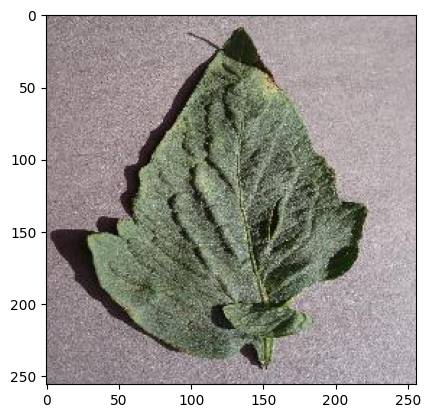

In [ ]:
predict_disease('/content/plantvillage/PlantVillage/Tomato__Target_Spot/03e19a2b-91f1-4404-a803-9a713c2ee618___Com.G_TgS_FL 9940.JPG')